In [91]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
import matplotlib.pylab as plt
%matplotlib inline

In [92]:
target = 'label'
IDcol = 'uid'

In [140]:
def modelfit(alg, dtrain, predictors, dtest, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])

    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['label'], eval_metric='auc')

    #Predict training set:
    dtrain_predictions = alg.predict(dtest[predictors])
    dtrain_predprob = alg.predict_proba(dtest[predictors])[:,1]
    #Print model report:

    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtest['label'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtest['label'], dtrain_predictions))
    print ("F1 Score (Train): %f" % metrics.f1_score(dtest['label'], dtrain_predictions))

    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

    return dtrain_predictions,dtrain_predprob

In [175]:
def down_sample(df):
    df1=df[df['label']==1]
    df2=df[df['label']==0]
    df3=df2.sample(frac=0.75)
    return pd.concat([df1,df3],ignore_index=True)

In [176]:
def up_sample(df):
    df1=df[df['label']==1]
    df2=df[df['label']==0]
    df3=pd.concat([df1,df1,df1],ignore_index=True)
    return pd.concat([df2,df3],ignore_index=True)

In [179]:
feature = pd.read_csv('train_feat.csv')
test_feature = pd.read_csv('test_feat.csv')
y = feature.label
x = feature.drop(['uid','label'],axis=1)
x_train,x_test= train_test_split(feature,test_size=0.2)
idx = []
uids = []
for i in range(0,1976):
    uid = test_feature['uid'][i]
    uids.append(int(uid.strip('u')))
for i in range(5000,6999):
    if i not in uids:
        index = uids.index(i-1)
        idx.append(index)
        uids.insert(index+1,i)
final_test_feature = test_feature.drop(['uid'],axis=1)
rest_uid = []
for i in range(0,len(idx)):
    rest_uid.append("u"+str(idx[i]+5001))
down_train = down_sample(x_train)
#print(down_train['label'].value_counts())
#print(up_sample(down_train)['label'].value_counts())
sampled_x_train = up_sample(down_train)


Model Report
Accuracy : 0.797
AUC Score (Train): 0.731603
F1 Score (Train): 0.522353


c:\users\win8.1\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


'\nlearning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]\nparam_grid = dict(learning_rate=learning_rate)\nkfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)\ngrid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)\ngrid_result = grid_search.fit(x_train, y_train)\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\n\n#model.fit(x_train, y_train)\n#model.fit(x, y)\n\nplot_importance(model)\npyplot.show()\n\n#y_pred = model.predict(final_test_feature)\ny_pred = model.predict(x_test)\npredictions = [round(value) for value in y_pred]\n\naccuracy = accuracy_score(y_test, predictions)\nroc_auc = roc_auc_score(y_test, predictions)\nf1 = f1_score(y_test, predictions)\nprint("Accuracy: %.2f%%" % (accuracy * 100.0))\nprint("roc_auc: %.2f%%" % (roc_auc * 100.0))\nprint("F1_score: %.2f%%" % (f1 * 100.0))\n'

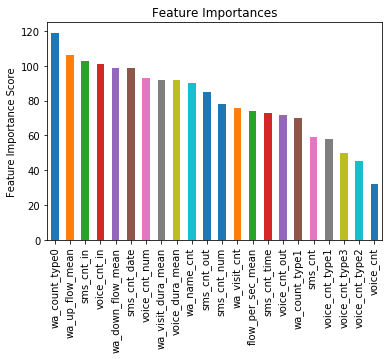

In [180]:
xgb1 = XGBClassifier(
    learning_rate=0.1,
    n_estimators=159,
    max_depth=4,
    min_child_weight=6,
    gamma=0.2,
    subsample=0.7,
    colsample_bytree=0.8,
    reg_alpha = 1.5,
    objective= 'binary:logistic',
    scale_pos_weight=1,
    seed=0)
#model = XGBClassifier(learning_rate=0.2)

predictors = [x for x in feature.columns if x not in [target,IDcol]]
#pred = modelfit(xgb1, feature, predictors, final_test_feature)
pred = modelfit(xgb1, sampled_x_train, predictors, x_test)

'''
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learning_rate=learning_rate)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(x_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

#model.fit(x_train, y_train)
#model.fit(x, y)

plot_importance(model)
pyplot.show()

#y_pred = model.predict(final_test_feature)
y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("roc_auc: %.2f%%" % (roc_auc * 100.0))
print("F1_score: %.2f%%" % (f1 * 100.0))
'''

In [117]:
res = pd.DataFrame()
temp = pd.DataFrame()
res['uid'] = test_feature['uid']
res['label'] = pred[0]
res['prob'] = pred[1]
temp['uid'] = rest_uid
temp['label'] = 0
temp['prob'] = 0
res = res.append(temp,ignore_index=True)
res = res.sort_values('prob',ascending=False)
print(res)
res.iloc[:,0:2].to_csv('res.csv',index=False,header=None)

ValueError: Length of values does not match length of index

In [11]:
param_test2 = {
 'max_depth':[2,3,4],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(     learning_rate=0.1, n_estimators=159, max_depth=3,
    min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
    param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(feature[predictors],feature[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

c:\users\win8.1\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.78733, std: 0.06208, params: {'max_depth': 2, 'min_child_weight': 4},
  mean: 0.78555, std: 0.06195, params: {'max_depth': 2, 'min_child_weight': 5},
  mean: 0.78783, std: 0.06204, params: {'max_depth': 2, 'min_child_weight': 6},
  mean: 0.79102, std: 0.05938, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: 0.79493, std: 0.05691, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.79120, std: 0.06377, params: {'max_depth': 3, 'min_child_weight': 6},
  mean: 0.79140, std: 0.06246, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: 0.79138, std: 0.06084, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: 0.79512, std: 0.05655, params: {'max_depth': 4, 'min_child_weight': 6}],
 {'max_depth': 4, 'min_child_weight': 6},
 0.7951184123013391)

In [6]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=159, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(feature[predictors],feature[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

c:\users\win8.1\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.79512, std: 0.05655, params: {'gamma': 0.0},
  mean: 0.79383, std: 0.06029, params: {'gamma': 0.1},
  mean: 0.79681, std: 0.05897, params: {'gamma': 0.2},
  mean: 0.79290, std: 0.06233, params: {'gamma': 0.3},
  mean: 0.79358, std: 0.06082, params: {'gamma': 0.4}],
 {'gamma': 0.2},
 0.7968055315656943)

In [9]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=159, max_depth=4,
 min_child_weight=6, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(feature[predictors],feature[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

c:\users\win8.1\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.79618, std: 0.04956, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.79629, std: 0.05903, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.79195, std: 0.05680, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.79808, std: 0.05414, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.79817, std: 0.05507, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.79075, std: 0.05662, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.79449, std: 0.06040, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.79664, std: 0.05967, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.79107, std: 0.05880, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.79845, std: 0.05680, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.79681, std: 0.05897, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.79634, std: 0.05713, params: {'colsample_bytree': 0.8, 'subsample'

In [15]:
param_test7 = {
 'reg_alpha':[0.5, 0.75, 1.5, 2, 3]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=159, max_depth=4,
 min_child_weight=6, gamma=0.2, subsample=0.7, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(feature[predictors],feature[target])
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

c:\users\win8.1\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.79799, std: 0.05509, params: {'reg_alpha': 0.5},
  mean: 0.79724, std: 0.05460, params: {'reg_alpha': 0.75},
  mean: 0.79876, std: 0.05671, params: {'reg_alpha': 1.5},
  mean: 0.79669, std: 0.05751, params: {'reg_alpha': 2},
  mean: 0.79594, std: 0.05857, params: {'reg_alpha': 5}],
 {'reg_alpha': 1.5},
 0.7987600434795559)